In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# scale data
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

# set seed for reproducibility
tf.random.set_seed(42)

In [55]:
# utilities
def initIndex(df):
  df['DateTime'] = pd.to_datetime(df['Unnamed: 0'])
  df = df.set_index('DateTime')
  df.drop(columns="Unnamed: 0", inplace=True)
  return df

In [56]:
# RNN requires data to be in 3 dimensions
# (batch_size, time_steps, num_features)
# reshape the data into 3D array
def generate_data(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [57]:
# Load pre-processed datasets
m1_hourly_sales = initIndex(pd.read_csv('datasets/compute/m1_hourly_sales.csv'))
m2_hourly_sales = initIndex(pd.read_csv('datasets/compute/m2_hourly_sales.csv'))
m3_hourly_sales = initIndex(pd.read_csv('datasets/compute/m3_hourly_sales.csv'))

In [58]:
# train 75% test 25%
m1_train_index = m1_hourly_sales.shape[0] * 0.75
m2_train_index = m2_hourly_sales.shape[0] * 0.75
m3_train_index = m3_hourly_sales.shape[0] * 0.75

# split train and test
m1_train = m1_hourly_sales[:int(m1_train_index)]
m1_test = m1_hourly_sales[int(m1_train_index):]

m2_train = m2_hourly_sales[:int(m2_train_index)]
m2_test = m2_hourly_sales[int(m2_train_index):]

m3_train = m3_hourly_sales[:int(m3_train_index)]
m3_test = m3_hourly_sales[int(m3_train_index):]

### Scaler

In [59]:
scaler = MinMaxScaler()
scaler.fit(m3_train[['amount']])
m3_scaled_train = scaler.transform(m3_train[['amount']])
m3_scaled_test = scaler.transform(m3_test[['amount']])

In [60]:
# define window size
window_size = 24

# generate data
X_train, y_train = generate_data(m3_scaled_train, window_size)
X_test, y_test = generate_data(m3_scaled_test, window_size)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(534, 24, 1)
(534, 1)
(162, 24, 1)
(162, 1)


### Research RNN Layer

In [61]:
# define LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(window_size, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 128)               66560     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 76929 (300.50 KB)
Trainable params: 76929 (300.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


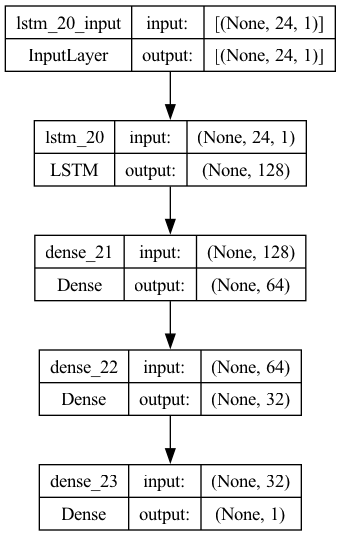

In [62]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
# fit model 
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 68ms/step - loss: 0.0240 - val_loss: 0.0264
Epoch 2/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0209 - val_loss: 0.0248
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0207 - val_loss: 0.0238
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0204 - val_loss: 0.0235
Epoch 5/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0202 - val_loss: 0.0231
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0203 - val_loss: 0.0229
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0203 - val_loss: 0.0231
Epoch 8/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0201 - val_loss: 0.0221
Epoch 9/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0208 - val_loss: 0.0238
Epoch 10/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0201 - val_loss: 0.0223

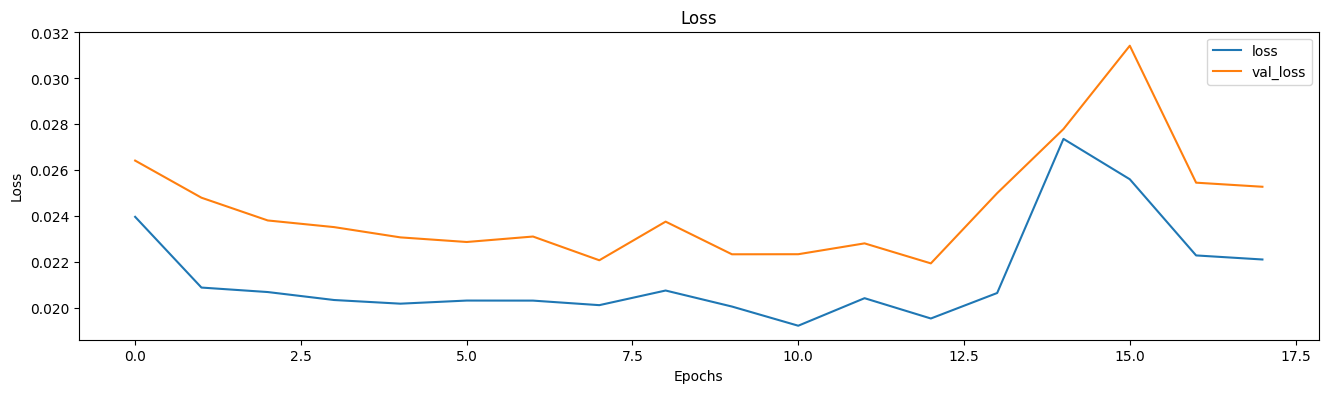

In [64]:
# plot loss
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(16, 4))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');


6/6 [==============================] - 0s 11ms/step


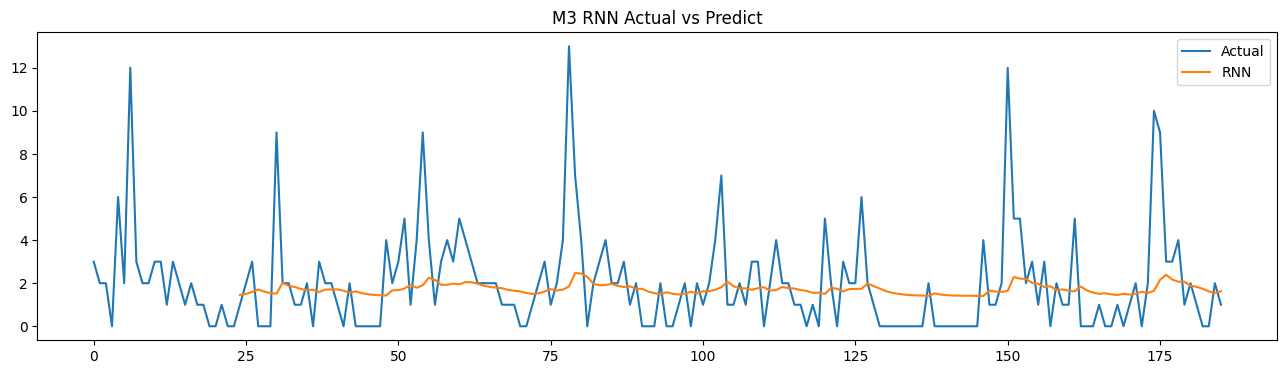

In [65]:
# plot actual vs predict
scaled_pred = model.predict(X_test)
pred = scaler.inverse_transform(scaled_pred)

plt.figure(figsize=(16, 4))
plt.plot(np.arange(len(m3_test['amount'].values)), m3_test['amount'].values, label='Actual')
plt.plot(np.arange(window_size, len(range(len(m3_test['amount'])))), pred, label='RNN')
plt.legend()
plt.title('M3 RNN Actual vs Predict');

### Grouping it to method and reuse

In [66]:
# grouping all process into method
def RNNevaluate(X_train, y_train, X_test, y_test, scaler, window_size):
  # fit model 
  model = Sequential()
  model.add(LSTM(32, input_shape=(window_size, 1)))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='mse')

  early_stop = EarlyStopping(monitor='val_loss', patience=3)

  model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

  # plot loss
  losses = pd.DataFrame(model.history.history)
  losses.plot(figsize=(16, 4))
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss');

  # predict
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  # inverse transform
  train_pred = scaler.inverse_transform(train_pred)
  test_pred = scaler.inverse_transform(test_pred)
  y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
  y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

  # evaluate
  train_mse = mean_squared_error(y_train, train_pred)
  test_mse = mean_squared_error(y_test, test_pred)
  print('Train MSE:', train_mse)
  print('Test  MSE:', test_mse)

  print('Train RMSE:', np.sqrt(train_mse))
  print('Test  RMSE:', np.sqrt(test_mse))

  # plot
  plt.figure(figsize=(16, 4))
  plt.plot(y_test, label='Actual')
  plt.plot(test_pred, label='RNN Predict')
  plt.legend()
  plt.title('RNN Actual vs Predict');

  return model

#### model declaration

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 32)                4352      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4897 (19.13 KB)
Trainable params: 4897 (19.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


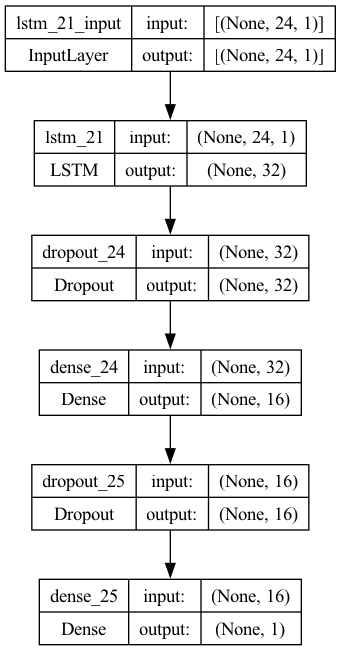

In [67]:
model = Sequential()
model.add(LSTM(32, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

model.summary()
plot_model(model, to_file='presentations/rnn-model.png', show_shapes=True, show_layer_names=True)

### run model

#### M1

Epoch 1/100
17/17 [==============================] - 2s 61ms/step - loss: 0.0557 - val_loss: 0.0419
Epoch 2/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0532 - val_loss: 0.0435
Epoch 3/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0531 - val_loss: 0.0413
Epoch 4/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0528 - val_loss: 0.0419
Epoch 5/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0516 - val_loss: 0.0404
Epoch 6/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0506 - val_loss: 0.0397
Epoch 7/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0480 - val_loss: 0.0376
Epoch 8/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0456 - val_loss: 0.0332
Epoch 9/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0451 - val_loss: 0.0336
Epoch 10/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0435 - val_loss: 0.0341

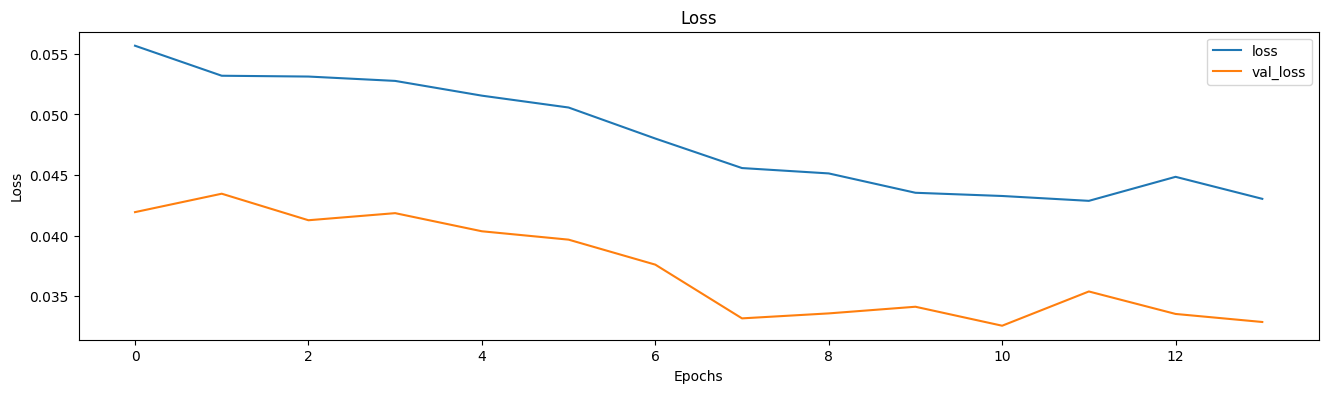

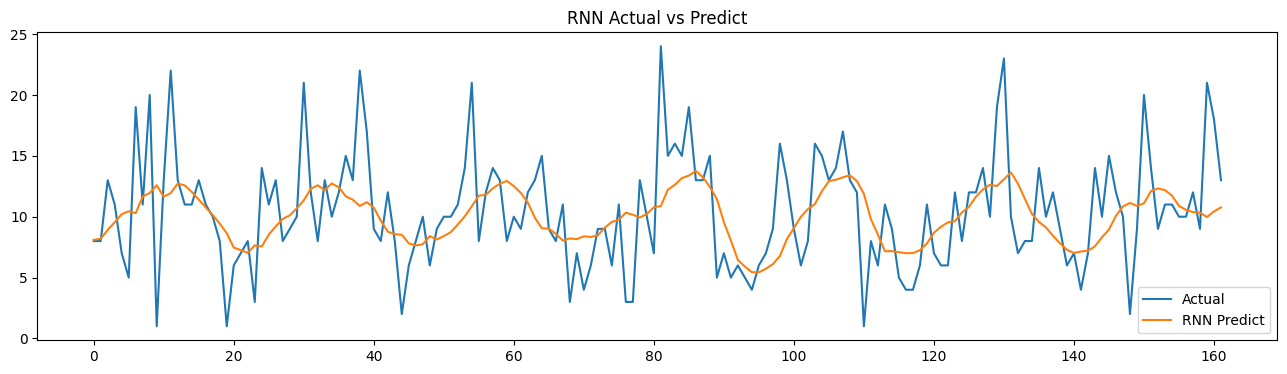

In [68]:
# M1 RNN evaluate
scaler = MinMaxScaler()
scaler.fit(m1_train[['amount']])
m1_scaled_train = scaler.transform(m1_train[['amount']])
m1_scaled_test = scaler.transform(m1_test[['amount']])

window_size = 24

# generate data
X_train, y_train = generate_data(m1_scaled_train, window_size)
X_test, y_test = generate_data(m1_scaled_test, window_size)

m1_model = RNNevaluate(X_train, y_train, X_test, y_test, scaler, window_size)

#### M2

Epoch 1/100
17/17 [==============================] - 3s 66ms/step - loss: 0.1376 - val_loss: 0.1322
Epoch 2/100
17/17 [==============================] - 0s 17ms/step - loss: 0.1255 - val_loss: 0.1208
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.1076 - val_loss: 0.0920
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0794 - val_loss: 0.0502
Epoch 5/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0574 - val_loss: 0.0400
Epoch 6/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0559 - val_loss: 0.0408
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0525 - val_loss: 0.0384
Epoch 8/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0472 - val_loss: 0.0347
Epoch 9/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0481 - val_loss: 0.0466
Epoch 10/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0498 - val_loss: 0.0374

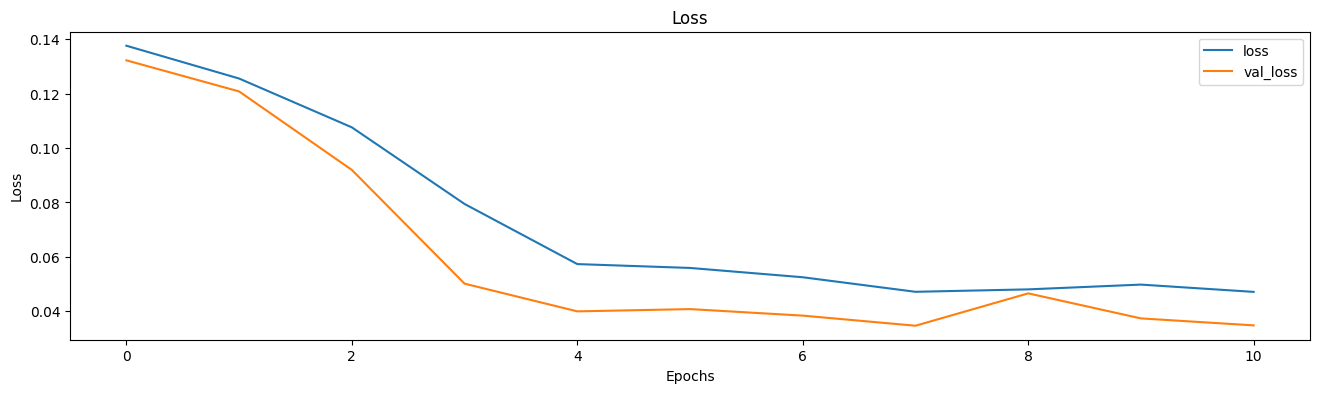

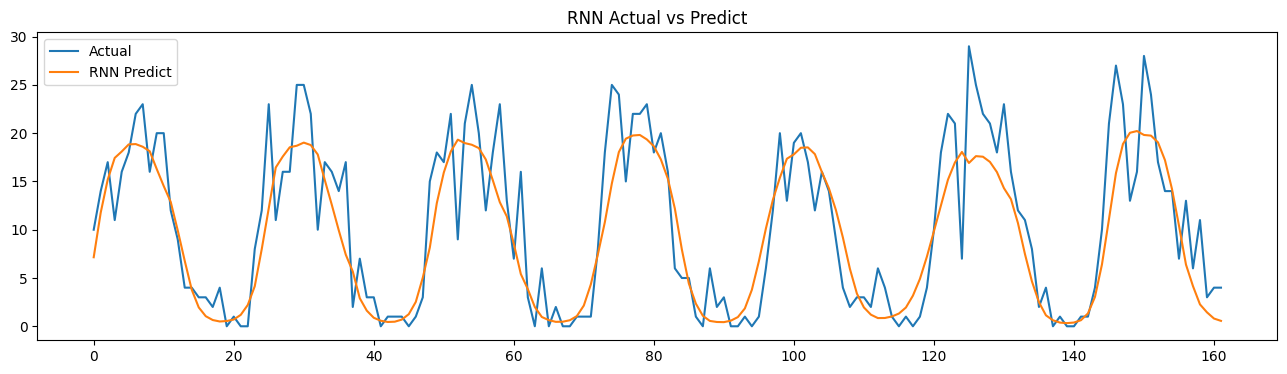

In [69]:
# M2 RNN evaluate
m2_scaler = MinMaxScaler()
m2_scaler.fit(m2_train[['amount']])
m2_scaled_train = scaler.transform(m2_train[['amount']])
m2_scaled_test = scaler.transform(m2_test[['amount']])

window_size = 24

# generate data
X_train, y_train = generate_data(m2_scaled_train, window_size)
X_test, y_test = generate_data(m2_scaled_test, window_size)

m2_model = RNNevaluate(X_train, y_train, X_test, y_test, scaler, window_size)

#### M3

Epoch 1/100
17/17 [==============================] - 2s 58ms/step - loss: 0.1422 - val_loss: 0.1089
Epoch 2/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0642 - val_loss: 0.0303
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0289 - val_loss: 0.0348
Epoch 4/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0279 - val_loss: 0.0284
Epoch 5/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0243 - val_loss: 0.0272
Epoch 6/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0254 - val_loss: 0.0280
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0248 - val_loss: 0.0274
Epoch 8/100
6/6 [==============================] - 0s 7ms/step
Train MSE: 4.541378541747814
Test  MSE: 5.456755603069082
Train RMSE: 2.1310510415632504
Test  RMSE: 2.3359699490937555


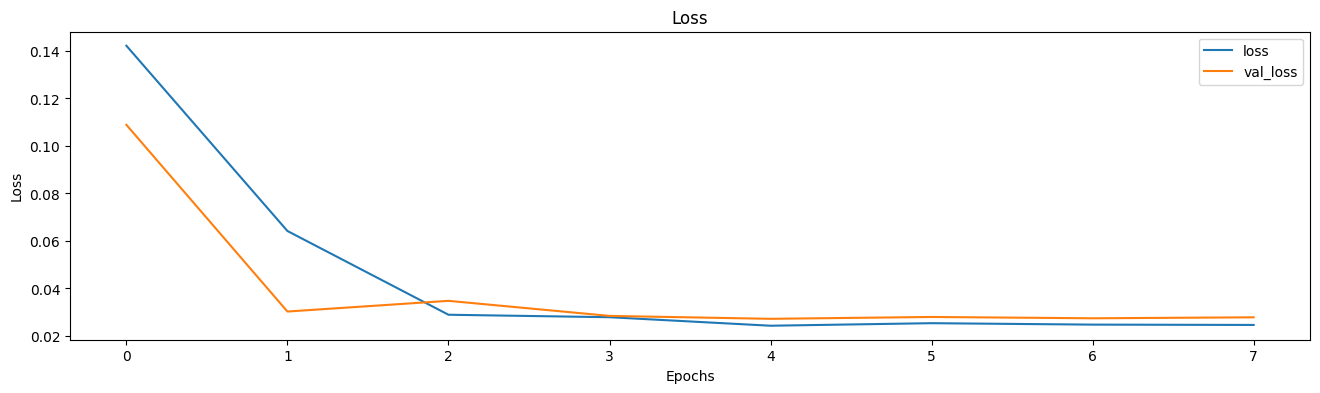

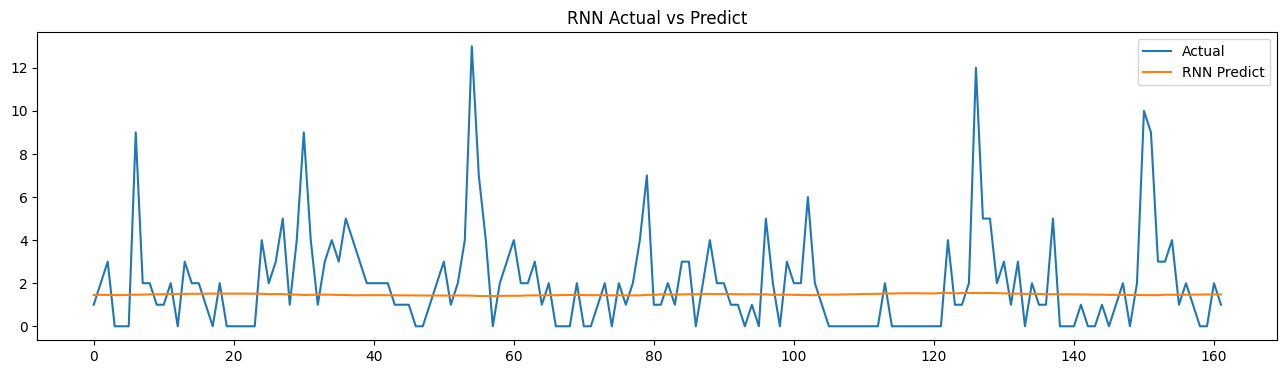

In [70]:
# M3 RNN evaluate
scaler = MinMaxScaler()
scaler.fit(m3_train[['amount']])
m3_scaled_train = scaler.transform(m3_train[['amount']])
m3_scaled_test = scaler.transform(m3_test[['amount']])

window_size = 24

# generate data
X_train, y_train = generate_data(m3_scaled_train, window_size)
X_test, y_test = generate_data(m3_scaled_test, window_size)

m3_model = RNNevaluate(X_train, y_train, X_test, y_test, scaler, window_size)

#### Model Usage 

In [71]:
def predict_next_n_hours(model, scaler, X_latest, n):
  window_size = 24
  prediction = []

  for i in range(n):
    next_value = model.predict(X_latest.reshape(1, window_size, 1))
    inversed_value = scaler.inverse_transform(next_value)
    prediction.append(inversed_value[0][0])
    X_latest = np.append(X_latest[1:], next_value[0][0])

  return prediction

In [72]:
# loop through predict to sum up transactions and check with transaction threshold
def should_refill_in(prediction, threshold=360):
  total = 0
  threshold = threshold
  for i in range(len(prediction)):
    total += prediction[i]
    if total >= threshold:
      print(f'Predicted transaction will reach {threshold} cups at next {i+1} hours')
      return i+1

1/1 [==============================] - 0s 12ms/step
Predicted transaction will reach 360 cups at next 34 hours


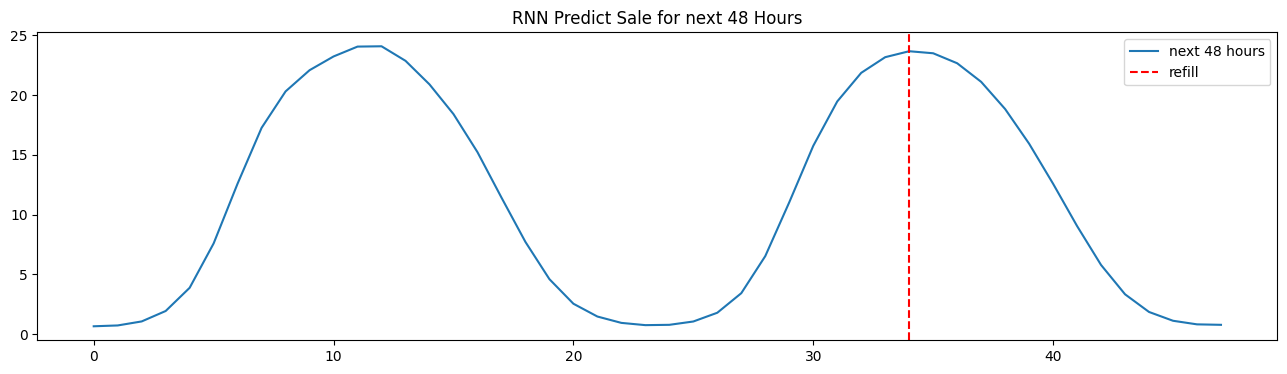

In [73]:
# When should M2 refill
n = 24 * 2
company_cups_threshold = 360

next_pred = predict_next_n_hours(m2_model, m2_scaler, m2_scaled_test[-window_size:], n)
refill_index = should_refill_in(next_pred, company_cups_threshold)

# plot
plt.figure(figsize=(16, 4))
plt.plot(next_pred, label=f'next {n} hours')
plt.axvline(x=refill_index, color='red', linestyle='--', label='refill')
plt.legend()
plt.title(f'RNN Predict Sale for next {n} Hours');


### Oops I forgot to add features into RNN

#### Prepare function and parameters

In [74]:
target = ['amount']
features = ['is_weekend', 'is_holiday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [87]:
# utility method to scale data
def scaleWithMinMaxScaler(df, target, features):
  target_scaler = MinMaxScaler().fit(df[target])
  df_scaled = pd.DataFrame(target_scaler.transform(df[target]), columns=target)

  features_scaler = MinMaxScaler().fit(df[features])
  df_scaled[features] = features_scaler.transform(df[features])
  return df_scaled, target_scaler

In [76]:
# utility method to generate data
def generate_multi_features_data(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i])
        y.append(data['amount'].iloc[i])
    return np.array(X), np.array(y)

In [89]:
# methods to evaluate model
def multiRNNevaluate(model, X_train, y_train, X_test, y_test, scaler):
  # fit model
  model.compile(optimizer='adam', loss='mse')

  early_stop = EarlyStopping(monitor='val_loss', patience=3)

  model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

  # plot loss
  losses = pd.DataFrame(model.history.history)
  losses.plot(figsize=(16, 4))
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss');

  # predict
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  # inverse transform
  train_pred = scaler.inverse_transform(train_pred)
  test_pred = scaler.inverse_transform(test_pred)
  y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
  y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

  # evaluate
  train_mse = mean_squared_error(y_train, train_pred)
  test_mse = mean_squared_error(y_test, test_pred)
  print('Train MSE:', train_mse)
  print('Test  MSE:', test_mse)

  print('Train RMSE:', np.sqrt(train_mse))
  print('Test  RMSE:', np.sqrt(test_mse))

  # plot
  plt.figure(figsize=(16, 4))
  plt.plot(y_test, label='Actual')
  plt.plot(test_pred, label='RNN Predict')
  plt.legend()
  plt.title('RNN Actual vs Predict');

  return model

#### RNN model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 24, 48)            11328     
                                                                 
 dropout_32 (Dropout)        (None, 24, 48)            0         
                                                                 
 lstm_26 (LSTM)              (None, 24, 48)            18624     
                                                                 
 dropout_33 (Dropout)        (None, 24, 48)            0         
                                                                 
 lstm_27 (LSTM)              (None, 24, 48)            18624     
                                                                 
 dropout_34 (Dropout)        (None, 24, 48)            0         
                                                                 
 lstm_28 (LSTM)              (None, 48)              

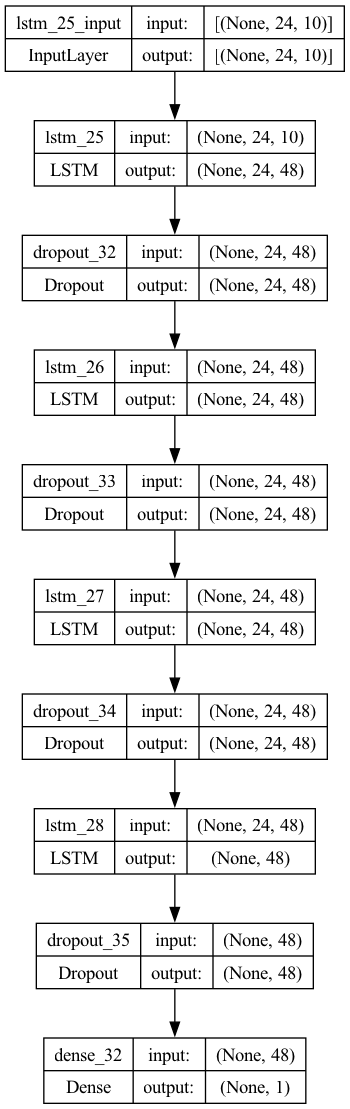

In [78]:
# multi features model
multiRNNmodel = Sequential()
multiRNNmodel.add(LSTM(48, return_sequences=True, input_shape=(24, 10)))
multiRNNmodel.add(Dropout(0.2))
multiRNNmodel.add(LSTM(units=48, return_sequences=True))
multiRNNmodel.add(Dropout(0.2))
multiRNNmodel.add(LSTM(units=48, return_sequences=True))
multiRNNmodel.add(Dropout(0.2))
multiRNNmodel.add(LSTM(units=48))
multiRNNmodel.add(Dropout(0.2))
multiRNNmodel.add(Dense(1))

multiRNNmodel.summary()
plot_model(multiRNNmodel, to_file='presentations/multi-rnn-model.png', show_shapes=True, show_layer_names=True)


#### M1

Epoch 1/100
17/17 [==============================] - 9s 232ms/step - loss: 0.0394 - val_loss: 0.0363
Epoch 2/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0374 - val_loss: 0.0337
Epoch 3/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0372 - val_loss: 0.0373
Epoch 4/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0381 - val_loss: 0.0368
Epoch 5/100
6/6 [==============================] - 0s 41ms/step
Train MSE: 20.598954425528248
Test  MSE: 20.199701555295704
Train RMSE: 4.538607101912243
Test  RMSE: 4.494407809188626


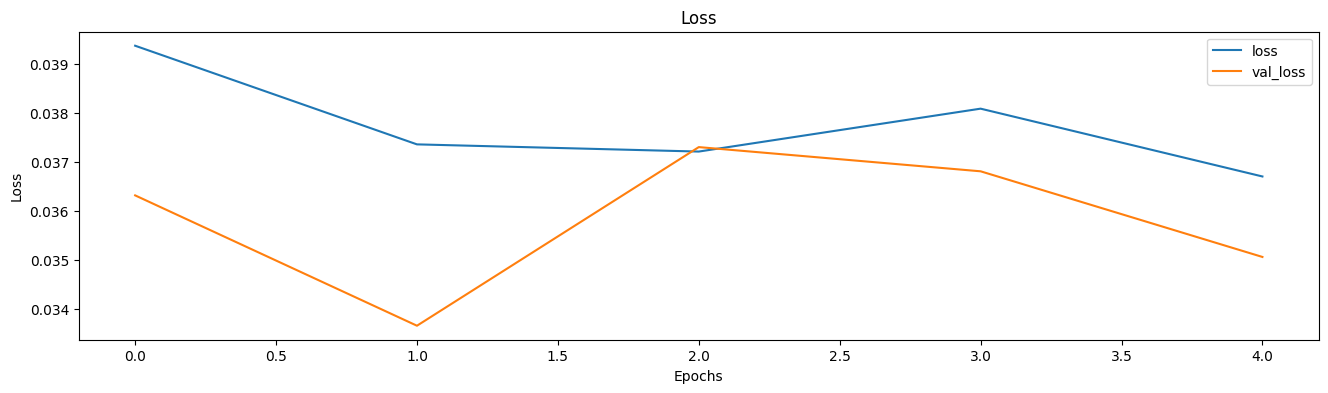

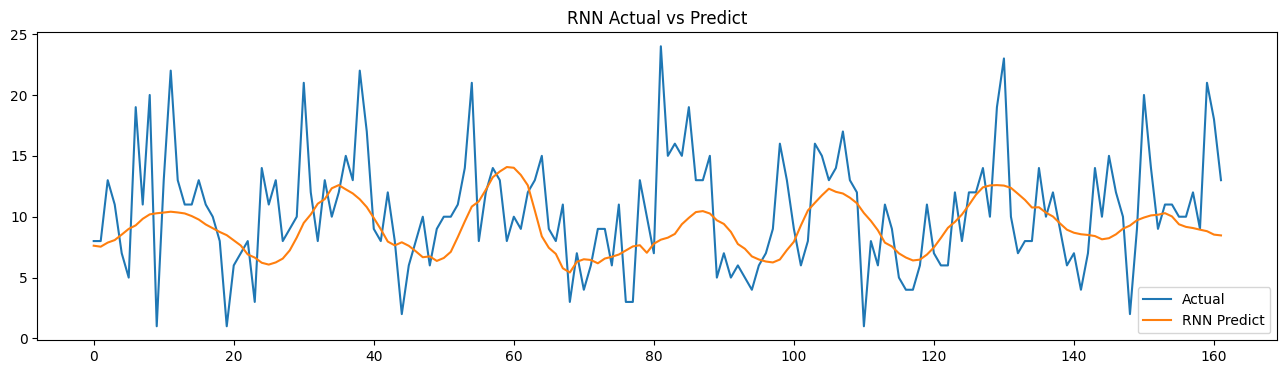

In [90]:
# scale the data
m1_scaled, target_scaler = scaleWithMinMaxScaler(m1_hourly_sales, target, features)

# find to df end
m1_train_index = m1_scaled.shape[0] * 0.75

# split test train
m1_train_scaled = m1_scaled[:int(m1_train_index)]
m1_test_scaled = m1_scaled[int(m1_train_index):]

# generate data
X_train, y_train = generate_multi_features_data(m1_train_scaled, window_size)
X_test, y_test = generate_multi_features_data(m1_test_scaled, window_size)

m1_multi_model = multiRNNevaluate(multiRNNmodel, X_train, y_train, X_test, y_test, target_scaler)

#### M2

Epoch 1/100
17/17 [==============================] - 9s 260ms/step - loss: 0.0349 - val_loss: 0.0197
Epoch 2/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0253 - val_loss: 0.0219
Epoch 3/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0222 - val_loss: 0.0227
Epoch 4/100
6/6 [==============================] - 0s 28ms/step
Train MSE: 18.425333890025865
Test  MSE: 18.46603916843789
Train RMSE: 4.29247409893477
Test  RMSE: 4.2972129535825765


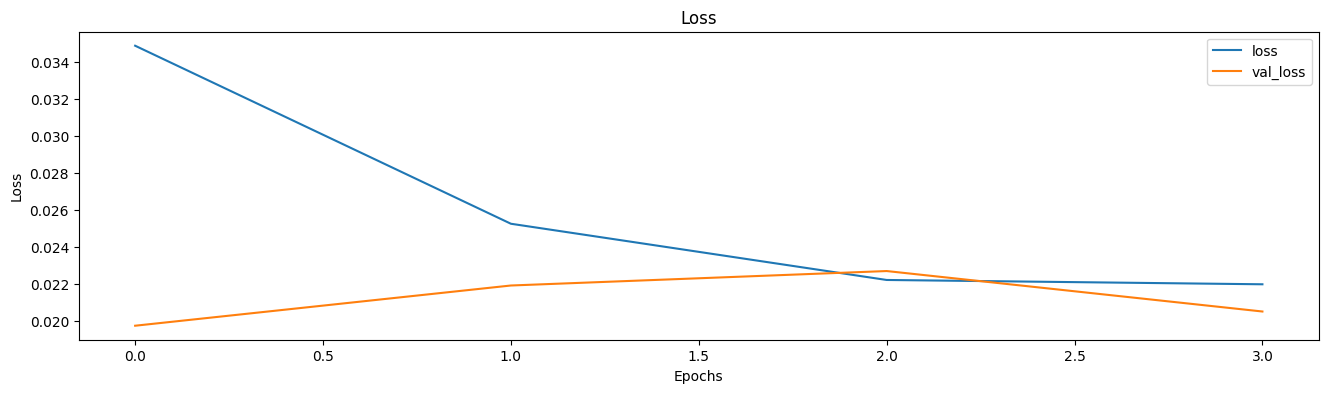

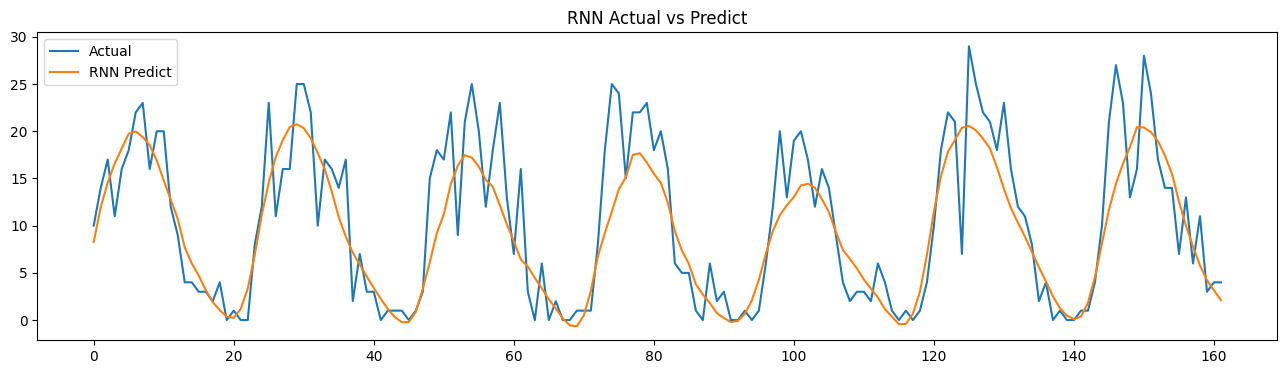

In [91]:
# scale the data
m2_scaled, target_scaler = scaleWithMinMaxScaler(m2_hourly_sales, target, features)

# find m3_train_index to end
m2_train_index = m2_scaled.shape[0] * 0.75

# split test train
m2_train_scaled = m2_scaled[:int(m2_train_index)]
m2_test_scaled = m2_scaled[int(m2_train_index):]

# generate data
X_train, y_train = generate_multi_features_data(m2_train_scaled, window_size)
X_test, y_test = generate_multi_features_data(m2_test_scaled, window_size)

m2_multi_model = multiRNNevaluate(multiRNNmodel, X_train, y_train, X_test, y_test, target_scaler)

#### M3


Epoch 1/100
17/17 [==============================] - 9s 232ms/step - loss: 0.0213 - val_loss: 0.0230
Epoch 2/100
17/17 [==============================] - 1s 53ms/step - loss: 0.0188 - val_loss: 0.0212
Epoch 3/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0180 - val_loss: 0.0208
Epoch 4/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0174 - val_loss: 0.0208
Epoch 5/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0173 - val_loss: 0.0213
Epoch 6/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0172 - val_loss: 0.0212
Epoch 7/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0180 - val_loss: 0.0206
Epoch 8/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0173 - val_loss: 0.0209
Epoch 9/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0175 - val_loss: 0.0212
Epoch 10/100
6/6 [==============================] - 0s 43ms/step
Train MSE: 3.2786613836080405
Test

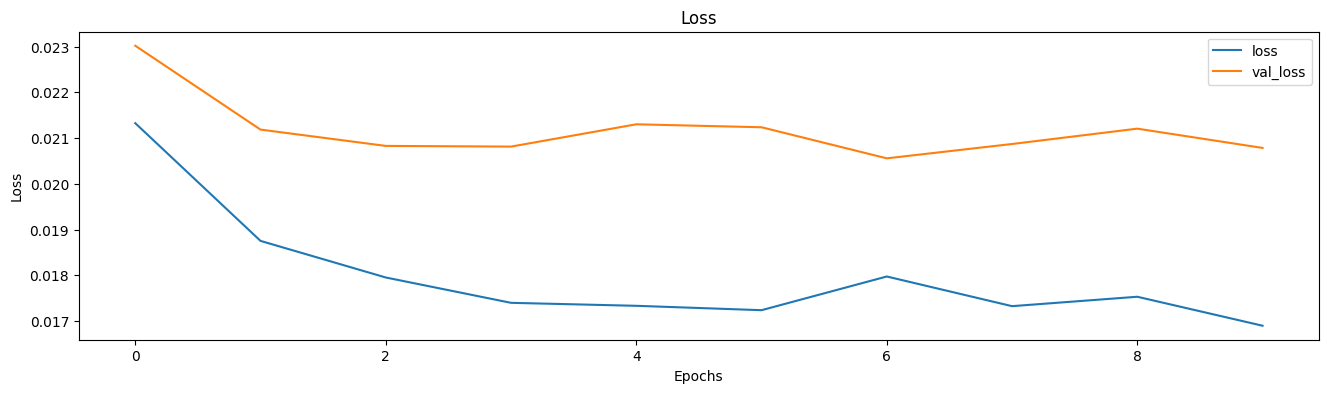

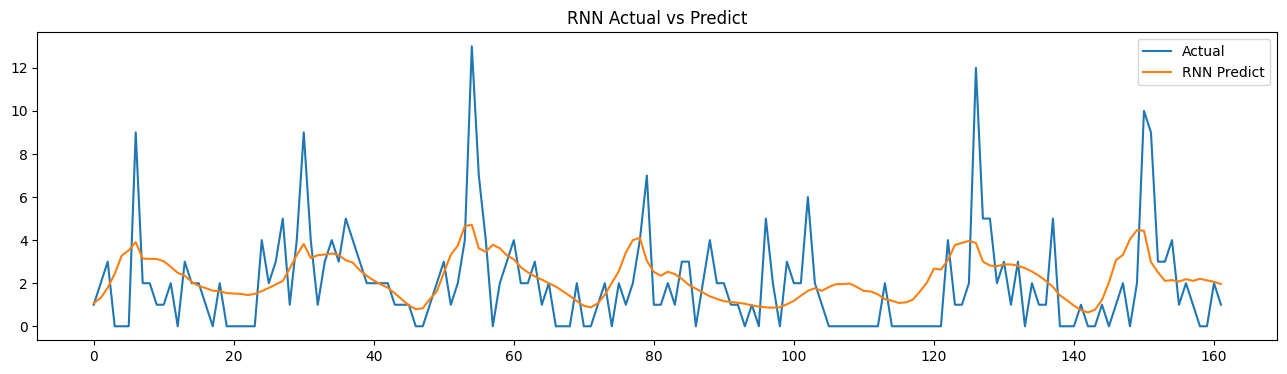

In [92]:
# scale the data
m3_scaled, target_scaler = scaleWithMinMaxScaler(m3_hourly_sales, target, features)

# find m3_train_index to end
m3_train_index = m3_scaled.shape[0] * 0.75

# split test train
m3_train_scaled = m3_scaled[:int(m3_train_index)]
m3_test_scaled = m3_scaled[int(m3_train_index):]

# generate data
X_train, y_train = generate_multi_features_data(m3_train_scaled, window_size)
X_test, y_test = generate_multi_features_data(m3_test_scaled, window_size)

m3_multi_model = multiRNNevaluate(multiRNNmodel, X_train, y_train, X_test, y_test, target_scaler)

#### Usage

1/1 [==============================] - 0s 13ms/step
Predicted transaction will reach 360 cups at next 34 hours


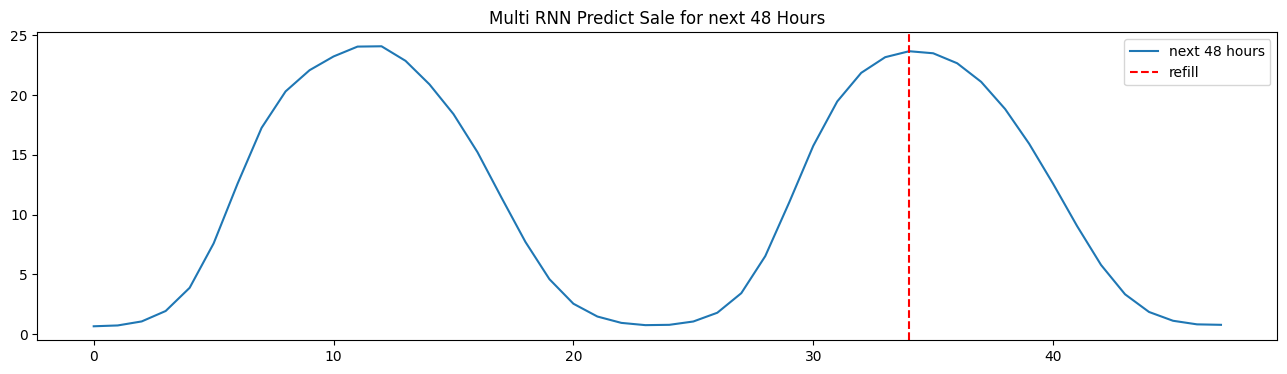

In [93]:
# When should M2 refill
n = 24 * 2
company_cups_threshold = 360

next_pred = predict_next_n_hours(m2_model, m2_scaler, m2_scaled_test[-window_size:], n)
refill_index = should_refill_in(next_pred, company_cups_threshold)

# plot
plt.figure(figsize=(16, 4))
plt.plot(next_pred, label=f'next {n} hours')
plt.axvline(x=refill_index, color='red', linestyle='--', label='refill')
plt.legend()
plt.title(f'Multi RNN Predict Sale for next {n} Hours');